In [1]:
# Benchmark neural network models

In [2]:
import os
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from nn_functions import (
    predict_batch,
    train_nn_models,
    define_model,
    load_models,
)

In [3]:
# download and save data
# !wget https://ngdc.noaa.gov/geomag/data/geomag/public.zip
# !unzip public.zip
# !wget https://ngdc.noaa.gov/geomag/data/geomag/private.zip
# !unzip private.zip
# !mkdir data2
# !mv public data2
# !mv private data2

In [4]:
# load data
data_folder = "data"
solar_train = pd.read_csv(os.path.join(data_folder, "public", "solar_wind.csv"))
dst_train = pd.read_csv(os.path.join(data_folder, "public", "dst_labels.csv"))
sunspots_train = pd.read_csv(os.path.join(data_folder, "public", "sunspots.csv"))
solar_test = pd.read_csv(os.path.join(data_folder, "private", "solar_wind.csv"))
dst_test = pd.read_csv(os.path.join(data_folder, "private", "dst_labels.csv"))
sunspots_test = pd.read_csv(os.path.join(data_folder, "private", "sunspots.csv"))

In [5]:
# train and save models
output_folder = os.path.join("trained_models", "cnn", "benchmark")
os.makedirs(output_folder, exist_ok=True)
# comment out training if model is already saved on disk
# train_nn_models(solar_train, sunspots_train, dst_train, define_model_cnn, 1, output_folder)

In [6]:
# measure performance on train and test
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)
dst_test["timedelta"] = pd.to_timedelta(dst_test["timedelta"])
# exclude times in the first week of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7)]
predictions = predict_batch(
    solar_test, sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df
)
dst_test = pd.merge(dst_test, predictions, "left", ["timedelta", "period"])
dst_test["dst_t_plus_1"] = dst_test.groupby("period")["dst"].shift(-1)
loss_t = np.sqrt(
    mean_squared_error(dst_test["dst"].values, dst_test["prediction_t"].values)
)
print(f"Performance for time t: {loss_t}")
valid_ind = dst_test["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)
print(f"Performance for time (t + 1): {loss_t_plus_1}")

Performance for t: 12.191240060717803
Performance for t plus 1: 12.23004365012702


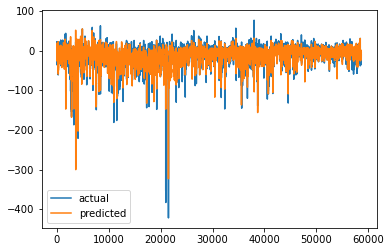

In [7]:
plt.figure()
plt.plot(dst_test.loc[valid_ind, "dst"].values)
plt.plot(dst_test.loc[valid_ind, "prediction_t"].values)
plt.legend(["actual", "predicted"])